# **Machine Learning Week 7**
---
> Introduction to Machine Learning <br>
> Sekolah Data, Pacmann

---
# Siapkan Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["font.size"] = 16

## **Prediksi karyawan left (1) atau tidak (0)**

*Cek Resiko dengan Sederhana*

- Salah prediksi karyawan stay - diprediksi stay, padahal resign/left
  - Resource bisa berkurang sehingga produktifitas menurun
  - Mengeluarkan cost untuk pesangon karyawan
  - Ada kemungkinan beberapa target tidak terkejar

- Salah prediksi karyawan left - diprediksi left, padahal stay
  - Sudah membuka job opening lebih dulu, HR bisa buang-buang waktu.
  - Mungkin melakukan restrukturisasi tim.

---
- Lebih besar resiko dari salah prediksi karyawan stay
- Apabila stay = negative (0) & left = positive (1)
- Maka kita ingin memperkecil nilai False Negative
- Dengan kata lain memperbesar nilai Recall

$$
\text{Recall} = \cfrac{TP}{TP + FN}
$$

**Import Data**

In [2]:
def importData(filename):
    # Read Data
    data = pd.read_csv(filename)
    print(f"shape awal                    : {data.shape}, (#observasi, #fitur)")

    # Drop duplicate
    data = data.drop_duplicates()
    print(f"shape setelah drop duplikat   : {data.shape}, (#observasi, #fitur)")

    return data


In [3]:
filename = "dataset/w7-data_hr.csv"
data = importData(filename = filename)

data.head()

shape awal                    : (14999, 10), (#observasi, #fitur)
shape setelah drop duplikat   : (11991, 10), (#observasi, #fitur)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,division,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


**Split Data Input-Ouput**

In [4]:
def splitInputOutput(data, target_column):
    X = data.drop(columns = target_column)
    y = data[target_column]

    return X, y

In [5]:
target_column = "left"
X, y = splitInputOutput(data = data,
                        target_column = target_column)

X.head, y.head

(<bound method NDFrame.head of        satisfaction_level  last_evaluation  number_project  \
 0                    0.38             0.53               2   
 1                    0.80             0.86               5   
 2                    0.11             0.88               7   
 3                    0.72             0.87               5   
 4                    0.37             0.52               2   
 ...                   ...              ...             ...   
 11995                0.90             0.55               3   
 11996                0.74             0.95               5   
 11997                0.85             0.54               3   
 11998                0.33             0.65               3   
 11999                0.50             0.73               4   
 
        average_montly_hours  time_spend_company  Work_accident  \
 0                       157                   3              0   
 1                       262                   6              0   
 2         

**Split Train-Test**

In [6]:
# Cek kondisi proporsi kelas target
y.value_counts(normalize = True)

# Tidak balance

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    test_size = 0.2,
                                                    random_state = 123)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9592, 9), (2399, 9), (9592,), (2399,))

**Splitting Categorical & Numerical Column**

In [8]:
X_train.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,division,salary
9492,0.44,0.56,3,123,3,0,0,accounting,medium
11555,0.98,0.44,4,154,6,1,0,sales,medium
11301,0.76,0.99,3,133,4,0,0,sales,low
5578,0.47,0.55,2,156,2,0,0,management,medium
6241,0.84,0.68,4,151,2,0,0,technical,low


In [9]:
categorical_col = ["Work_accident", "promotion_last_5years", "division", "salary"]
numerical_col = list(set(X_train.columns) - set(categorical_col))

categorical_col, numerical_col

(['Work_accident', 'promotion_last_5years', 'division', 'salary'],
 ['average_montly_hours',
  'last_evaluation',
  'number_project',
  'time_spend_company',
  'satisfaction_level'])

In [10]:
def splitNumCat(data, num_col, cat_col):
    data_num = data[num_col]
    data_cat = data[cat_col]

    return data_num, data_cat

In [11]:
X_train_num, X_train_cat = splitNumCat(data = X_train,
                                       num_col = numerical_col,
                                       cat_col = categorical_col)

**Handling Numerical Data**

In [12]:
# Check missing value
X_train_num.isna().any()

average_montly_hours    False
last_evaluation         False
number_project          False
time_spend_company      False
satisfaction_level      False
dtype: bool

In [13]:
# Buat imputer untuk jaga-jaga apabila di data test ada yang kosong
from sklearn.impute import SimpleImputer

def imputerNum(data, imputer = None):
    if imputer == None:
        # Buat imputer
        imputer = SimpleImputer(missing_values = np.nan,
                                strategy = "median")
        imputer.fit(data)

    # Transform data dengan imputer
    data_imputed = imputer.transform(data)
    data_imputed = pd.DataFrame(data_imputed,
                                index = data.index,
                                columns = data.columns)
    
    return data_imputed, imputer


In [14]:
X_train_num_imputed, imputer_num = imputerNum(data = X_train_num)

In [15]:
X_train_num_imputed.head()

,average_montly_hours,last_evaluation,number_project,time_spend_company,satisfaction_level
9492,123.0,0.56,3.0,3.0,0.44
11555,154.0,0.44,4.0,6.0,0.98
11301,133.0,0.99,3.0,4.0,0.76
5578,156.0,0.55,2.0,2.0,0.47
6241,151.0,0.68,4.0,2.0,0.84


**Handling Categorical Data**

In [16]:
# Check missing value
X_train_cat.isna().any()
X_train_cat.isna().sum()

Work_accident            0
promotion_last_5years    0
division                 0
salary                   0
dtype: int64

In [17]:
# Buat imputer untuk jaga-jaga apabila di data test ada yang kosong
def imputerCat(data, imputer = None):
    if imputer == None:
        # Buat imputer
        imputer = SimpleImputer(missing_values = np.nan,
                                strategy = "constant",
                                fill_value = "UNKNOWN")
        imputer.fit(data)

    # Transform data dengan imputer
    data_imputed = imputer.transform(data)
    data_imputed = pd.DataFrame(data_imputed,
                                index = data.index,
                                columns = data.columns)
    
    return data_imputed, imputer


In [18]:
X_train_cat_imputed, imputer_cat = imputerCat(data = X_train_cat)

In [19]:
X_train_cat_imputed.head()

,Work_accident,promotion_last_5years,division,salary
9492,0,0,accounting,medium
11555,1,0,sales,medium
11301,0,0,sales,low
5578,0,0,management,medium
6241,0,0,technical,low


**One Hot Encoding Data**

In [20]:
from sklearn.preprocessing import OneHotEncoder

def encoderCat(data, encoder_col = None, encoder = None):
    if encoder == None:
        # Buat objek
        encoder = OneHotEncoder(handle_unknown = "ignore",
                                drop = "if_binary")
        encoder.fit(data)
        encoder_col = encoder.get_feature_names_out(data.columns)

    # Transform data
    data_encoded = encoder.transform(data).toarray()
    data_encoded = pd.DataFrame(data_encoded,
                                index = data.index,
                                columns = encoder_col)
    
    return data_encoded, encoder_col, encoder


In [21]:
X_train_cat_encoded, encoder_col, encoder_OHE = encoderCat(data = X_train_cat_imputed)

In [22]:
X_train_cat_imputed.head().T

,9492,11555,11301,5578,6241
Work_accident,0,1,0,0,0
promotion_last_5years,0,0,0,0,0
division,accounting,sales,sales,management,technical
salary,medium,medium,low,medium,low


In [23]:
X_train_cat_encoded.head().T

,9492,11555,11301,5578,6241
Work_accident_1,0.0,1.0,0.0,0.0,0.0
promotion_last_5years_1,0.0,0.0,0.0,0.0,0.0
division_IT,0.0,0.0,0.0,0.0,0.0
division_RandD,0.0,0.0,0.0,0.0,0.0
division_accounting,1.0,0.0,0.0,0.0,0.0
division_hr,0.0,0.0,0.0,0.0,0.0
division_management,0.0,0.0,0.0,1.0,0.0
division_marketing,0.0,0.0,0.0,0.0,0.0
division_product_mng,0.0,0.0,0.0,0.0,0.0
division_sales,0.0,1.0,1.0,0.0,0.0


In [24]:
encoder_col

array(['Work_accident_1', 'promotion_last_5years_1', 'division_IT',
       'division_RandD', 'division_accounting', 'division_hr',
       'division_management', 'division_marketing',
       'division_product_mng', 'division_sales', 'division_support',
       'division_technical', 'salary_high', 'salary_low', 'salary_medium'],
      dtype=object)

**Concat Data**

In [25]:
X_train_concat = pd.concat([X_train_num_imputed, X_train_cat_encoded],
                           axis = 1)
X_train_concat.head()

,average_montly_hours,last_evaluation,number_project,time_spend_company,satisfaction_level,Work_accident_1,promotion_last_5years_1,division_IT,division_RandD,division_accounting,division_hr,division_management,division_marketing,division_product_mng,division_sales,division_support,division_technical,salary_high,salary_low,salary_medium
9492,123.0,0.56,3.0,3.0,0.44,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11555,154.0,0.44,4.0,6.0,0.98,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
11301,133.0,0.99,3.0,4.0,0.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5578,156.0,0.55,2.0,2.0,0.47,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6241,151.0,0.68,4.0,2.0,0.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


**Balancing Data: SMOTE**

In [26]:
# Cek missing values
X_train_concat.isna().any()

average_montly_hours       False
last_evaluation            False
number_project             False
time_spend_company         False
satisfaction_level         False
Work_accident_1            False
promotion_last_5years_1    False
division_IT                False
division_RandD             False
division_accounting        False
division_hr                False
division_management        False
division_marketing         False
division_product_mng       False
division_sales             False
division_support           False
division_technical         False
salary_high                False
salary_low                 False
salary_medium              False
dtype: bool

In [27]:
from imblearn.over_sampling import SMOTE

In [28]:
y_train.value_counts()

left
0    7999
1    1593
Name: count, dtype: int64

In [29]:
len(y_train)

9592

In [30]:
# Buat objek
smt = SMOTE(sampling_strategy = "minority",
            random_state = 123)

# Fit objek
X_train_smote, y_train = smt.fit_resample(X_train_concat, y_train)

In [31]:
y_train.value_counts()

left
0    7999
1    7999
Name: count, dtype: int64

**Scale Data**

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
def standardizeData(data, scaler = None):
    if scaler == None:
        # Buat & Fit scaler
        scaler = StandardScaler()
        scaler.fit(data)

    # Tranform data
    data_scaled = scaler.transform(data)
    data_scaled = pd.DataFrame(data_scaled,
                               index = data.index,
                               columns = data.columns)
    
    return data_scaled, scaler


In [34]:
X_train_clean, scaler = standardizeData(data = X_train_smote)
X_train_clean.head()

,average_montly_hours,last_evaluation,number_project,time_spend_company,satisfaction_level,Work_accident_1,promotion_last_5years_1,division_IT,division_RandD,division_accounting,division_hr,division_management,division_marketing,division_product_mng,division_sales,division_support,division_technical,salary_high,salary_low,salary_medium
0,-1.486434,-0.890660,-0.578327,-0.471206,-0.431486,-0.351352,-0.110301,-0.29828,-0.235598,4.616884,-0.249114,-0.185243,-0.256206,-0.255321,-0.658910,-0.441542,-0.502866,-0.244239,-1.077731,1.203543
1,-0.914857,-1.560918,0.110938,2.008961,1.603606,2.972531,-0.110301,-0.29828,-0.235598,-0.241361,-0.249114,-0.185243,-0.256206,-0.255321,1.619952,-0.441542,-0.502866,-0.244239,-1.077731,1.203543
2,-1.302054,1.511096,-0.578327,0.355516,0.774495,-0.351352,-0.110301,-0.29828,-0.235598,-0.241361,-0.249114,-0.185243,-0.256206,-0.255321,1.619952,-0.441542,-0.502866,-0.244239,0.954483,-0.853658
3,-0.877981,-0.946515,-1.267592,-1.297929,-0.318425,-0.351352,-0.110301,-0.29828,-0.235598,-0.241361,-0.249114,5.982144,-0.256206,-0.255321,-0.658910,-0.441542,-0.502866,-0.244239,-1.077731,1.203543
4,-0.970171,-0.220403,0.110938,-1.297929,1.075990,-0.351352,-0.110301,-0.29828,-0.235598,-0.241361,-0.249114,-0.185243,-0.256206,-0.255321,-0.658910,-0.441542,2.137885,-0.244239,0.954483,-0.853658


In [35]:
X_train_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
average_montly_hours,15998.0,-4.974421e-17,1.000031,-1.984258,-0.968767,0.025478,0.910500,1.961463
last_evaluation,15998.0,3.837410e-16,1.000031,-2.007757,-1.002370,0.114726,0.930489,1.566951
number_project,15998.0,1.918705e-16,1.000031,-1.267592,-0.845364,0.110938,0.800203,2.178733
time_spend_company,15998.0,-2.700400e-16,1.000031,-1.297929,-0.471206,-0.471206,0.355516,5.315851
satisfaction_level,15998.0,-5.685053e-17,1.000031,-1.750527,-0.625009,0.020757,0.887555,1.678980
Work_accident_1,15998.0,8.527579e-17,1.000031,-0.351352,-0.351352,-0.351352,-0.351352,2.972531
promotion_last_5years_1,15998.0,3.553158e-17,1.000031,-0.110301,-0.110301,-0.110301,-0.110301,9.332984
division_IT,15998.0,-1.776579e-18,1.000031,-0.298280,-0.298280,-0.298280,-0.298280,3.686392
division_RandD,15998.0,-7.461631e-17,1.000031,-0.235598,-0.235598,-0.235598,-0.235598,4.629700
division_accounting,15998.0,-9.238210e-17,1.000031,-0.241361,-0.241361,-0.241361,-0.241361,4.616884


**Transform Test Data**

In [36]:
def transformTestData(data, num_col, cat_col, encoder_col,
                      imputer_num, imputer_cat, encoder_cat,
                      scaler):
    # 1. Split num-cat
    data_num, data_cat = splitNumCat(data = data,
                                     num_col = num_col,
                                     cat_col = cat_col)
    
    # 2. Handling num
    data_num_imputed, _ = imputerNum(data = data_num,
                                     imputer = imputer_num)
    
    # 3. Handling cat
    data_cat_imputed, _ = imputerCat(data = data_cat,
                                     imputer = imputer_cat)
    data_cat_encoded, _, _ = encoderCat(data = data_cat_imputed,
                                        encoder_col = encoder_col,
                                        encoder = encoder_cat)
    
    # 4. Concat data
    data_concat = pd.concat([data_num_imputed, data_cat_encoded],
                            axis = 1)
    
    # 5. Scale data
    data_clean, _ = standardizeData(data = data_concat,
                                    scaler = scaler)
    
    return data_clean


In [37]:
X_test_clean = transformTestData(data = X_test,
                                 num_col = numerical_col, 
                                 cat_col = categorical_col,
                                 encoder_col = encoder_col,
                                 imputer_num = imputer_num,
                                 imputer_cat = imputer_cat,
                                 encoder_cat = encoder_OHE,
                                 scaler = scaler)

X_test_clean.head()

,average_montly_hours,last_evaluation,number_project,time_spend_company,satisfaction_level,Work_accident_1,promotion_last_5years_1,division_IT,division_RandD,division_accounting,division_hr,division_management,division_marketing,division_product_mng,division_sales,division_support,division_technical,salary_high,salary_low,salary_medium
8578,-0.232653,1.287677,1.489468,2.008961,1.000616,-0.351352,-0.110301,-0.29828,-0.235598,4.616884,-0.249114,-0.185243,-0.256206,-0.255321,-0.658910,-0.441542,-0.502866,-0.244239,-1.077731,1.203543
5756,1.168632,0.784984,0.800203,0.355516,-1.411345,-0.351352,-0.110301,-0.29828,-0.235598,4.616884,-0.249114,-0.185243,-0.256206,-0.255321,-0.658910,-0.441542,-0.502866,-0.244239,-1.077731,1.203543
3994,-0.804229,1.455241,0.110938,-1.297929,0.284565,-0.351352,-0.110301,-0.29828,-0.235598,-0.241361,-0.249114,-0.185243,-0.256206,-0.255321,1.619952,-0.441542,-0.502866,-0.244239,-1.077731,1.203543
1784,-1.007047,-1.169934,-1.267592,-0.471206,-0.469173,2.972531,-0.110301,-0.29828,-0.235598,4.616884,-0.249114,-0.185243,-0.256206,-0.255321,-0.658910,-0.441542,-0.502866,-0.244239,-1.077731,1.203543
10508,0.762997,1.455241,0.110938,-0.471206,-0.167677,-0.351352,-0.110301,-0.29828,-0.235598,-0.241361,-0.249114,-0.185243,-0.256206,-0.255321,-0.658910,2.443568,-0.502866,-0.244239,-1.077731,1.203543


In [38]:
X_test_clean.columns

Index(['average_montly_hours', 'last_evaluation', 'number_project',
       'time_spend_company', 'satisfaction_level', 'Work_accident_1',
       'promotion_last_5years_1', 'division_IT', 'division_RandD',
       'division_accounting', 'division_hr', 'division_management',
       'division_marketing', 'division_product_mng', 'division_sales',
       'division_support', 'division_technical', 'salary_high', 'salary_low',
       'salary_medium'],
      dtype='object')

In [39]:
X_train_clean.columns

Index(['average_montly_hours', 'last_evaluation', 'number_project',
       'time_spend_company', 'satisfaction_level', 'Work_accident_1',
       'promotion_last_5years_1', 'division_IT', 'division_RandD',
       'division_accounting', 'division_hr', 'division_management',
       'division_marketing', 'division_product_mng', 'division_sales',
       'division_support', 'division_technical', 'salary_high', 'salary_low',
       'salary_medium'],
      dtype='object')

In [40]:
len(X_train_clean.columns)

20

*Done*

---
# Multi-Layer Perceptron (Neural Network)

- Mengadaptasi cara sel otak transfer & mengolah informasi.
- Satuan terkecilnya adalah Neuron (Perceptron)

<center>
<img src="https://blog.camelot-group.com/wp-content/uploads/2022/01/Perceptron_byCamelot.png">
<br>
<a href="https://blog.camelot-group.com/2022/01/neural-networks-perceptron/">source</a>
</center>

- 1 Perceptron dapat menerima beberapa input
- 1 Perceptron mengeluarkan 1 output
- Input-input akan dijumlahkan secara berbobot dahulu (`preActivation`)
- Kemudian akan diaktifasi menggunakan `activation function` seperti Sigmoid, ReLU, TanH, dan sebagainya.

---
## Feed Propagation
- Misal kita ingin selesaikan kasus klasifikasi
- Kita buat arsitektur Neural Network dengan 1 perceptron

In [41]:
def preActivation(X, w):
    """
    Fungsi untuk mendapatkan nilai pre activation (weighted-sum)
    :param X: <pandas DataFrame> data input
    :param w: <numpy array> weight dari masing-masing input
    :return a: <numpy array> weighted sum atau pre activation
    """
    a = np.dot(X, w[1:]) + w[0]

    return a

In [42]:
def activationFunction(a, types):
    """
    Fungsi untuk melakukan aktifasi nilai pre activation
    :param a: <numpy array> pre activation value
    :param types: <str> pilihan fungsi aktivasi
    :return y: <numpy array> output perceptron
    """
    if types == "linear":
        y = a
    elif types == "sigmoid":
        y = 1 / (1 + np.exp(-a))
    elif types == "relu":
        y = np.max(0, a)
    else:
        raise Exception("Activation Function tidak terdaftar")

    return y

In [43]:
len(X_train_clean.columns)

20

*Lakukan Forward Propagation*

In [44]:
# Buat random weight
# Ada 20 weight & 1 bias
w = np.random.rand(21)
w

array([0.57449884, 0.78541241, 0.52501689, 0.17655319, 0.35957077,
       0.74095781, 0.13777551, 0.77897692, 0.11284185, 0.10971568,
       0.22706039, 0.91274294, 0.65177998, 0.33426857, 0.49826937,
       0.5194492 , 0.81866789, 0.26563116, 0.92234792, 0.80450646,
       0.75752603])

*pada data train*

In [45]:
# Cari pre-activation function
a = preActivation(X = X_train_clean,
                  w = w)

In [46]:
# Cari output --> activate the pre-activation
# Karena klasifikasi, activation function menggunakan Sigmoid
y_pred_proba_train = activationFunction(a = a,
                                        types = "sigmoid")

<Axes: ylabel='Count'>

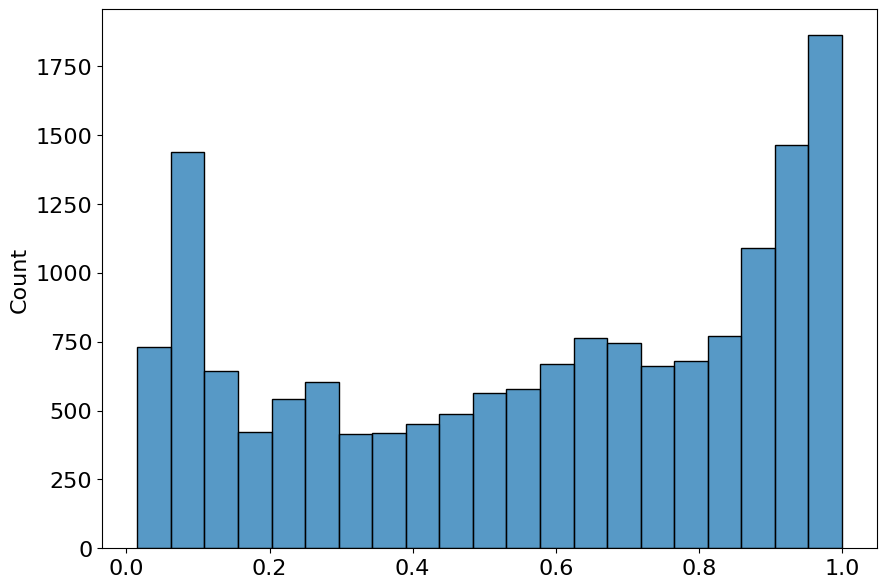

In [47]:
sns.histplot(y_pred_proba_train)

In [48]:
# Buat prediksi
thresh = 0.5

y_pred_train = (y_pred_proba_train > thresh).astype("int")

In [80]:
y_pred_train

array([0, 1, 1, ..., 1, 1, 1])

*pada data test*

In [49]:
# Cari pre-activation function
a = preActivation(X = X_test_clean,
                  w = w)

In [50]:
# Cari output --> activate the pre-activation
# Karena klasifikasi, activation function menggunakan Sigmoid
y_pred_proba_test = activationFunction(a = a,
                                       types = "sigmoid")

In [51]:
# Buat prediksi
y_pred_test = (y_pred_proba_test > thresh).astype("int")

*cek performa*

In [52]:
# Cari performa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

*pada data train*

In [53]:
# Tampilkan confusion matrix
confusion_matrix(y_true = y_train,
                 y_pred = y_pred_train)

array([[2817, 5182],
       [3502, 4497]])

In [54]:
# Tampilkan score
accuracy_score(y_true = y_train,
               y_pred = y_pred_train)

0.45718214776847105

In [55]:
# Tampilkan score
print(classification_report(y_true = y_train,
                            y_pred = y_pred_train,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.45      0.35      0.39      7999
    left (1)       0.46      0.56      0.51      7999

    accuracy                           0.46     15998
   macro avg       0.46      0.46      0.45     15998
weighted avg       0.46      0.46      0.45     15998



**Baseline**
- karena data sudah balance, accuracy baseline adalah 50%
- model ini lebih buruk dibanding baseline, jadi harus diimprove

**Focus**
- `weighted_avg recall` bernilai 0.49, artinya dari yang **benar-benar** left, hanya 49% yang berhasil diprediksi left.
- Berarti masih ada hampir 50% karyawan yang left tapi salah prediksi, dengan kata lain resikonya besar.
- Kita ingin kecilkan hal tersebut

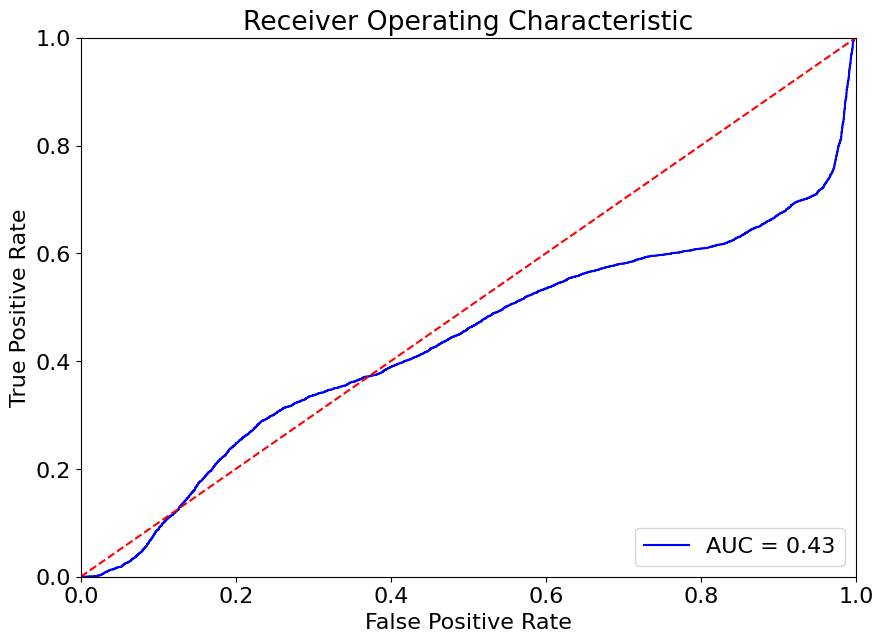

In [56]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_train,
                                         y_pred_proba_train)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*pada data test*

In [57]:
# Tampilkan confusion matrix
confusion_matrix(y_true = y_test,
                 y_pred = y_pred_test)

array([[ 685, 1316],
       [ 183,  215]])

In [58]:
# Tampilkan score
accuracy_score(y_true = y_test,
               y_pred = y_pred_test)

0.3751563151313047

In [59]:
# Tampilkan score
print(classification_report(y_true = y_test,
                            y_pred = y_pred_test,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.79      0.34      0.48      2001
    left (1)       0.14      0.54      0.22       398

    accuracy                           0.38      2399
   macro avg       0.46      0.44      0.35      2399
weighted avg       0.68      0.38      0.44      2399



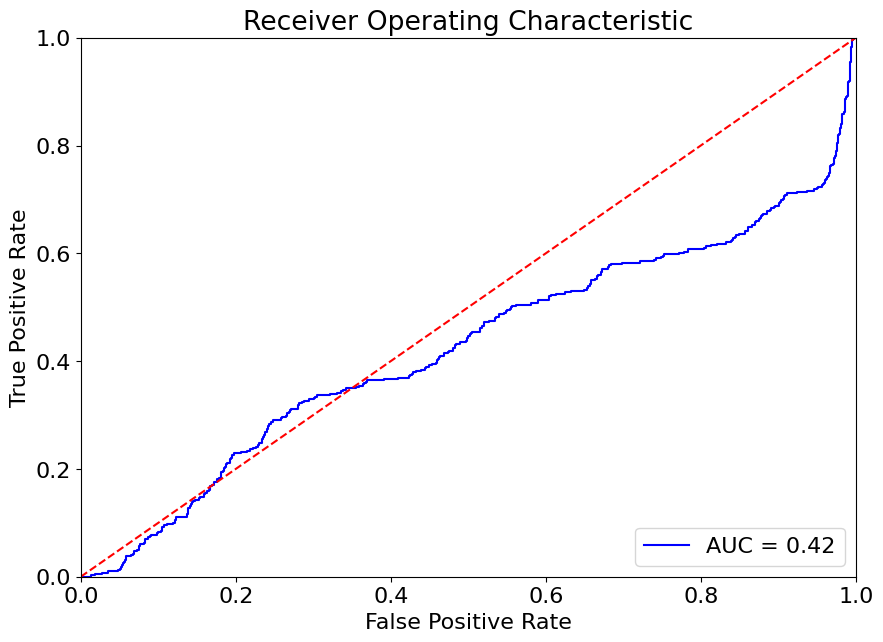

In [60]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test,
                                         y_pred_proba_test)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Masih jelek, ingin kita improve

---
# Gradient Descent

- Akurasi model random masih kecil, ingin kita tingkatkan
- Artinya, **weight** ingin kita optimasi
- Dapat dioptimasi menggunakan **Gradient Descent**

<center>
<img src="https://static.javatpoint.com/tutorial/machine-learning/images/gradient-descent-in-machine-learning1.png">
<br>
<a href="https://www.javatpoint.com/gradient-descent-in-machine-learning">source</a>
</center>

Algoritma:
- Inisialisasi weight, *bisa random*
- Cari gradient error terhadap weight
- Lakukan update weight dari informasi gradient tersebut

$$
w_{\text{new}} = w_{\text{old}} - \nabla_{w} E
$$

- Ulangi hingga stopping criteria tercapai (max. iteration atau weight tidak berubah --> $\nabla_{w} E = 0$)

---
# Backpropagation & Gradient Descent

$$
\begin{align*}
a^{(i)} &= w_{0} + w_{1}x_{1}^{(i)} + w_{2}x_{2}^{(i)} + \cdots + w_{20}x_{20}^{(i)} \\
\hat{y}^{(i)} &= \sigma (a^{(i)}) = \cfrac{1}{1 + \exp(-a^{(i)})}\\ 
\text{error}^{(i)} &= (y^{(i)} - \hat{y}^{(i)})^{2}
\end{align*}
$$

Cari gradient error menggunakan chain rules

$$
\begin{align*}
\cfrac{\partial \text{error}}{\partial w_{0}} &= \cfrac{\partial \text{error}}{\partial \hat{y}} \cdot \cfrac{\partial \hat{y}}{\partial a} \cdot \cfrac{\partial a}{\partial w_{0}} \\ \\
\cfrac{\partial \text{error}}{\partial w_{1}} &= \cfrac{\partial \text{error}}{\partial \hat{y}} \cdot \cfrac{\partial \hat{y}}{\partial a} \cdot \cfrac{\partial a}{\partial w_{1}} \\ \\
\cfrac{\partial \text{error}}{\partial w_{2}} &= \cfrac{\partial \text{error}}{\partial \hat{y}} \cdot \cfrac{\partial \hat{y}}{\partial a} \cdot \cfrac{\partial a}{\partial w_{2}} \\ \\
\vdots \\ \\ 
\cfrac{\partial \text{error}}{\partial w_{20}} &= \cfrac{\partial \text{error}}{\partial \hat{y}} \cdot \cfrac{\partial \hat{y}}{\partial a} \cdot \cfrac{\partial a}{\partial w_{20}}
\end{align*}
$$

Maka didapat

$$
\begin{align*}
\cfrac{\partial \text{error}}{\partial \hat{y}} &= -2 (y - \hat{y}) \\ \\
\cfrac{\partial \hat{y}}{\partial a} &= \sigma(a)(1 - \sigma(a)) \\ \\
\cfrac{\partial a}{\partial w_{0}} &= 1 \\ \\
\cfrac{\partial a}{\partial w_{1}} &= x_{1} \\ \\
\cfrac{\partial a}{\partial w_{2}} &= x_{2} \\ \\
\vdots \\ \\
\cfrac{\partial a}{\partial w_{20}} &= x_{20}
\end{align*}
$$

In [ ]:
def gradientDescent(X, y, 
                    learning_rate, max_iter, 
                    epsilon = 1e-6):
    """
    Fungsi untuk melakukan update weight
    """
    X = np.array(X)
    n = X.shape[0]          # banyak data
    p = X.shape[1] + 1      # banyak parameter

    # Inisialisasi weights
    w = np.ones(p)

    # Inisialisasi
    w_hist = []
    loss_hist = []
    iter = 0
    previous_loss = 0

    # Lakukan iterasi
    for iter in range(max_iter):
        # Buat prediksi
        a = preActivation(X = X, w = w)
        y_pred = activationFunction(a = a, types = "sigmoid")

        # Cari error
        current_loss = np.linalg.norm(y - y_pred)**2 ## RSS
        
        if np.abs(previous_loss - current_loss) < epsilon:
            break

        # Update
        previous_loss = current_loss
        loss_hist.append(current_loss)
        w_hist.append(w)
        
        # Cari gradient error
        derr_dy = -2 * (y - y_pred)
        dy_da = y_pred * (1 - y_pred)
        
        derr_dw = np.zeros(p)
        for j in range(p):
            # Cari da_dw_j
            if j == 0:
                da_dw = np.ones(n)
            else:
                da_dw = X[:, j-1]
            
            # Cari error
            derr_dw[j] = np.sum(derr_dy * dy_da * da_dw)


        # Update weight dari gradient error
        for j in range(p):
            w[j] = w[j] - learning_rate * derr_dw[j]

        if iter%100 == 0:
            print(f"iterasi {iter+1} - Loss: {current_loss:.4f}")

    # Print last iteration
    print(f"iterasi {iter+1} - Loss: {current_loss:.4f}")

    return loss_hist, w_hist

In [62]:
loss_hist, w_hist = gradientDescent(X = X_train_clean,
                                    y = y_train,
                                    learning_rate = 0.01,
                                    max_iter = 5000)

iterasi 1 - Loss: 7488.9291
iterasi 101 - Loss: 1964.5390
iterasi 201 - Loss: 1979.5720
iterasi 301 - Loss: 1977.2009
iterasi 401 - Loss: 1975.2473
iterasi 501 - Loss: 1974.6624
iterasi 601 - Loss: 1974.2861
iterasi 701 - Loss: 1974.0228
iterasi 801 - Loss: 1973.8315
iterasi 901 - Loss: 1973.6896
iterasi 1001 - Loss: 1973.5827
iterasi 1101 - Loss: 1973.5015
iterasi 1201 - Loss: 1973.4391
iterasi 1301 - Loss: 1973.3909
iterasi 1401 - Loss: 1973.3535
iterasi 1501 - Loss: 1973.3243
iterasi 1601 - Loss: 1973.3016
iterasi 1701 - Loss: 1973.2837
iterasi 1801 - Loss: 1973.2697
iterasi 1901 - Loss: 1973.2587
iterasi 2001 - Loss: 1973.2501
iterasi 2101 - Loss: 1973.2433
iterasi 2201 - Loss: 1973.2379
iterasi 2301 - Loss: 1973.2337
iterasi 2401 - Loss: 1973.2303
iterasi 2501 - Loss: 1973.2277
iterasi 2601 - Loss: 1973.2256
iterasi 2701 - Loss: 1973.2240
iterasi 2801 - Loss: 1973.2227
iterasi 2901 - Loss: 1973.2217
iterasi 3001 - Loss: 1973.2209
iterasi 3101 - Loss: 1973.2202
iterasi 3201 - Loss:

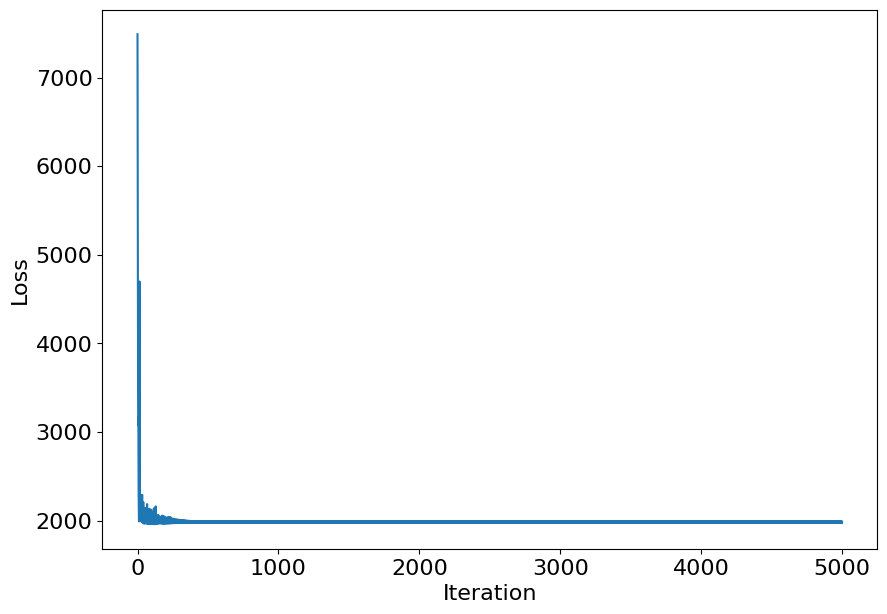

In [63]:
# Plot Error history
plt.plot([i for i in range(len(loss_hist))], loss_hist)
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.show()

In [64]:
# Cari best weights
w_best = w_hist[-1]
w_best

array([ -2.45893172,  -0.0449544 ,   0.86434723,  -7.08326657,
        18.48650381, -10.43313379,  -0.82744534,  -3.70713583,
         0.80331553,   0.42532654,   0.5879857 ,   0.83426641,
         0.43036978,   0.8611298 ,   0.83983843,   1.68152344,
         0.9767835 ,   1.40652648,   0.13774149,   1.42480806,
         0.96734897])

In [82]:
len(w_best)

21

*pada data train*

In [65]:
# Cari pre-activation function
a = preActivation(X = X_train_clean,
                  w = w_best)

In [66]:
# Cari output --> activate the pre-activation
# Karena klasifikasi, activation function menggunakan Sigmoid
y_pred_proba_train = activationFunction(a = a,
                                        types = "sigmoid")

In [67]:
# Buat prediksi
thresh = 0.5

y_pred_train = (y_pred_proba_train > thresh).astype("int")

*pada data test*

In [68]:
# Cari pre-activation function
a = preActivation(X = X_test_clean,
                  w = w_best)

In [69]:
# Cari output --> activate the pre-activation
# Karena klasifikasi, activation function menggunakan Sigmoid
y_pred_proba_test = activationFunction(a = a,
                                       types = "sigmoid")

In [70]:
# Buat prediksi
y_pred_test = (y_pred_proba_test > thresh).astype("int")

*cek performa*

*pada data train*

In [71]:
# Tampilkan confusion matrix
confusion_matrix(y_true = y_train,
                 y_pred = y_pred_train)

array([[6308, 1691],
       [ 364, 7635]])

In [72]:
# Tampilkan score
accuracy_score(y_true = y_train,
               y_pred = y_pred_train)

0.8715464433054132

In [73]:
# Tampilkan score
print(classification_report(y_true = y_train,
                            y_pred = y_pred_train,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.95      0.79      0.86      7999
    left (1)       0.82      0.95      0.88      7999

    accuracy                           0.87     15998
   macro avg       0.88      0.87      0.87     15998
weighted avg       0.88      0.87      0.87     15998



- Ada perbaikan recall, tadinya 49% sekarang jadi 87%
- Membaik

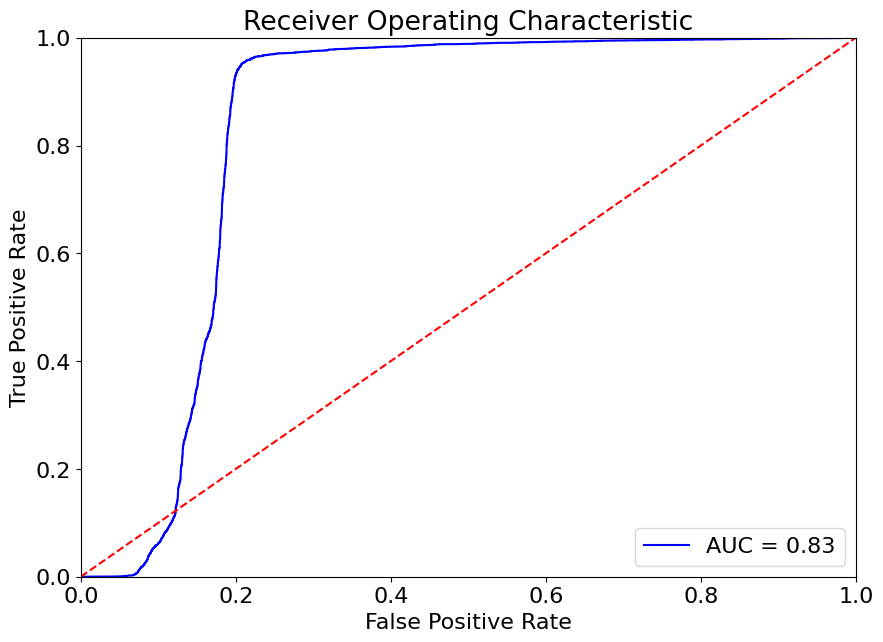

In [74]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_train,
                                         y_pred_proba_train)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*pada data test*

In [75]:
# Tampilkan confusion matrix
confusion_matrix(y_true = y_test,
                 y_pred = y_pred_test)

array([[1545,  456],
       [  24,  374]])

In [76]:
# Tampilkan score
accuracy_score(y_true = y_test,
               y_pred = y_pred_test)

0.7999166319299709

In [77]:
# Tampilkan score
print(classification_report(y_true = y_test,
                            y_pred = y_pred_test,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.98      0.77      0.87      2001
    left (1)       0.45      0.94      0.61       398

    accuracy                           0.80      2399
   macro avg       0.72      0.86      0.74      2399
weighted avg       0.90      0.80      0.82      2399



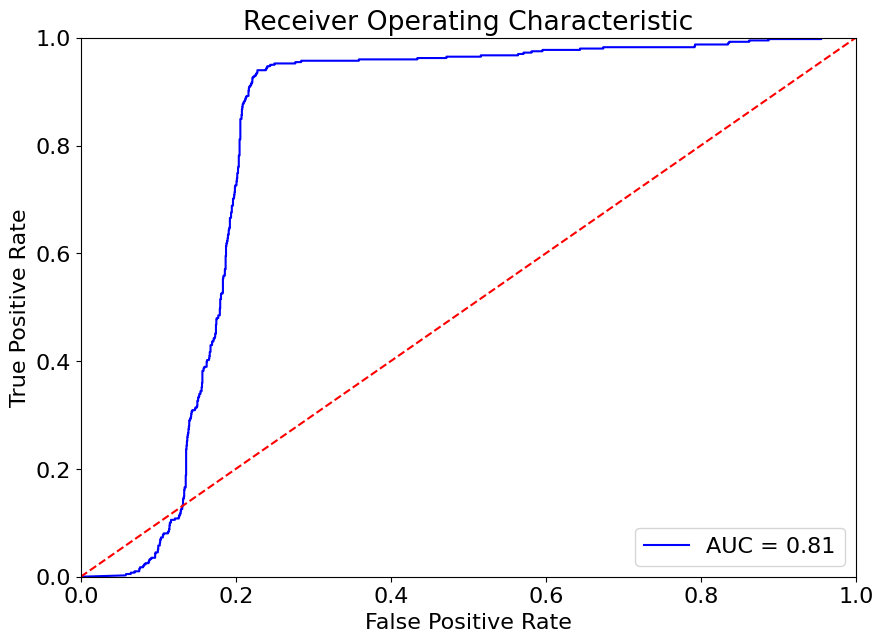

In [78]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test,
                                         y_pred_proba_test)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

---
# Membuat Model Neural Network

In [79]:
# Import library
import tensorflow as tf
from tensorflow import keras
# from keras import layers, models
# from keras.layers import Dense
# from keras.models import Sequential, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

TypeError: unhashable type: 'list'

**Arsitektur Simpel**

In [ ]:
# Buat arsitektur model dengan 1 perceptron
model = Sequential([
    Dense(1, input_shape = (X_train_clean.shape[1],), activation = "sigmoid")
])

# Buat optimizer, menggunakan ADAM (varian gradient descent)
opt = SGD(learning_rate = 0.01)

# Compile model
model.compile(loss = "binary_crossentropy",
              optimizer = opt,
              metrics = ["accuracy"])

NameError: name 'Sequential' is not defined

In [ ]:
# Train model
model_hist = model.fit(X_train_clean, y_train,
                       epochs = 10,
                       verbose = 1)

NameError: name 'model' is not defined

In [ ]:
# Summary Model
model.summary()

In [ ]:
# Plot Error
plt.plot(1 + np.arange(10), model_hist.history["loss"], marker="o")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

NameError: name 'model_hist' is not defined

*pada data train*

In [ ]:
# Prediksi
y_pred_proba_train = model.predict(X_train_clean)
y_pred_proba_train

NameError: name 'model' is not defined

In [83]:
# Buat prediksi
thresh = 0.5

y_pred_train = (y_pred_proba_train > thresh).astype("int")

*pada data test*

In [84]:
# Prediksi
y_pred_proba_test = model.predict(X_test_clean)
y_pred_proba_test

NameError: name 'model' is not defined

In [85]:
# Buat prediksi
y_pred_test = (y_pred_proba_test > thresh).astype("int")

*cek performa*

*pada data train*

In [86]:
# Tampilkan confusion matrix
confusion_matrix(y_true = y_train,
                 y_pred = y_pred_train)

array([[6308, 1691],
       [ 364, 7635]])

In [87]:
# Tampilkan score
accuracy_score(y_true = y_train,
               y_pred = y_pred_train)

0.8715464433054132

In [88]:
# Tampilkan score
print(classification_report(y_true = y_train,
                            y_pred = y_pred_train,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.95      0.79      0.86      7999
    left (1)       0.82      0.95      0.88      7999

    accuracy                           0.87     15998
   macro avg       0.88      0.87      0.87     15998
weighted avg       0.88      0.87      0.87     15998



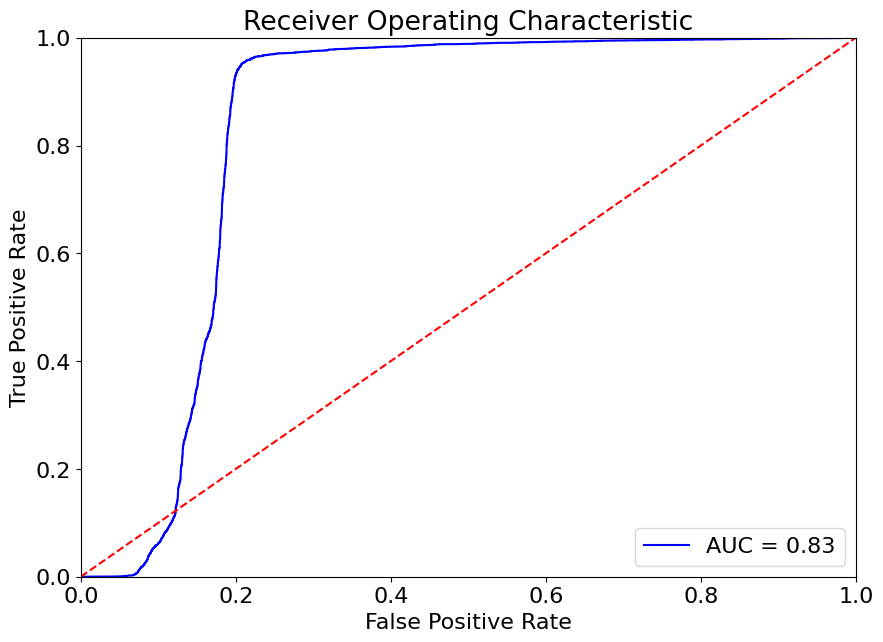

In [89]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_train,
                                         y_pred_proba_train)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*pada data test*

In [90]:
# Tampilkan confusion matrix
confusion_matrix(y_true = y_test,
                 y_pred = y_pred_test)

array([[1545,  456],
       [  24,  374]])

In [91]:
# Tampilkan score
accuracy_score(y_true = y_test,
               y_pred = y_pred_test)

0.7999166319299709

In [92]:
# Tampilkan score
print(classification_report(y_true = y_test,
                            y_pred = y_pred_test,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.98      0.77      0.87      2001
    left (1)       0.45      0.94      0.61       398

    accuracy                           0.80      2399
   macro avg       0.72      0.86      0.74      2399
weighted avg       0.90      0.80      0.82      2399



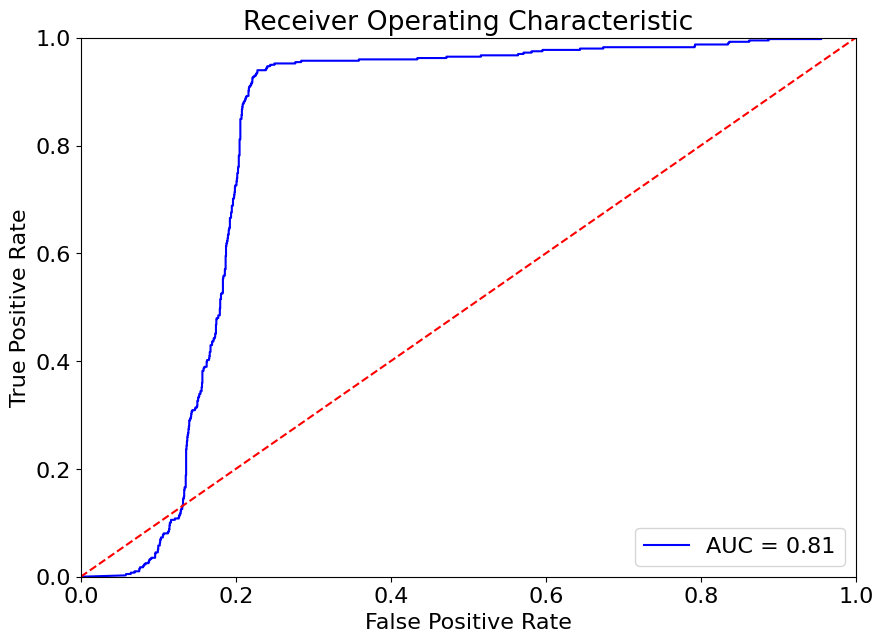

In [93]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test,
                                         y_pred_proba_test)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Arsitektur Lebih Kompleks**

- 1 hidden layer, dengan 3 neuron

In [94]:
# Buat arsitektur model dengan 1 perceptron
model = Sequential([
    Dense(3, input_shape = (X_train_clean.shape[1],), activation = "sigmoid"),
    Dense(1, activation = "sigmoid")
])

# Buat optimizer, menggunakan ADAM (varian gradient descent)
opt = SGD(learning_rate = 0.01)

# Compile model
model.compile(loss = "binary_crossentropy",
              optimizer = opt,
              metrics = ["accuracy"])

NameError: name 'Sequential' is not defined

In [95]:
# Train model
model_hist = model.fit(X_train_clean, y_train,
                       epochs = 10,
                       verbose = 1)

NameError: name 'model' is not defined

In [96]:
# Summary Model
model.summary()

NameError: name 'model' is not defined

In [97]:
# Plot Error
plt.plot(1 + np.arange(10), model_hist.history["loss"], marker="o")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

NameError: name 'model_hist' is not defined

In [98]:
# Train model - Teruskan 100 iterasi lagi
model_hist = model.fit(X_train_clean, y_train,
                       epochs = 100,
                       verbose = 1)

NameError: name 'model' is not defined

In [99]:
# Plot Error
plt.plot(1 + np.arange(100), model_hist.history["loss"], marker="o")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

NameError: name 'model_hist' is not defined

*pada data train*

In [100]:
# Prediksi
y_pred_proba_train = model.predict(X_train_clean)
y_pred_proba_train

NameError: name 'model' is not defined

In [101]:
# Buat prediksi
thresh = 0.5

y_pred_train = (y_pred_proba_train > thresh).astype("int")

*pada data test*

In [102]:
# Prediksi
y_pred_proba_test = model.predict(X_test_clean)
y_pred_proba_test

NameError: name 'model' is not defined

In [103]:
# Buat prediksi
y_pred_test = (y_pred_proba_test > thresh).astype("int")

*cek performa*

*pada data train*

In [104]:
# Tampilkan confusion matrix
confusion_matrix(y_true = y_train,
                 y_pred = y_pred_train)

array([[6308, 1691],
       [ 364, 7635]])

In [105]:
# Tampilkan score
accuracy_score(y_true = y_train,
               y_pred = y_pred_train)

0.8715464433054132

In [106]:
# Tampilkan score
print(classification_report(y_true = y_train,
                            y_pred = y_pred_train,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.95      0.79      0.86      7999
    left (1)       0.82      0.95      0.88      7999

    accuracy                           0.87     15998
   macro avg       0.88      0.87      0.87     15998
weighted avg       0.88      0.87      0.87     15998



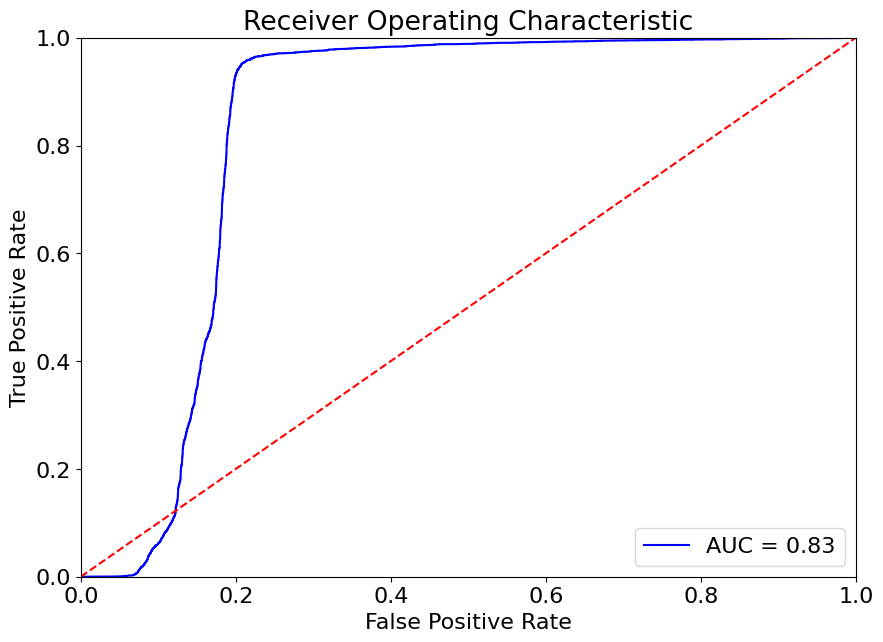

In [107]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_train,
                                         y_pred_proba_train)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*pada data test*

In [108]:
# Tampilkan confusion matrix
confusion_matrix(y_true = y_test,
                 y_pred = y_pred_test)

array([[1545,  456],
       [  24,  374]])

In [109]:
# Tampilkan score
accuracy_score(y_true = y_test,
               y_pred = y_pred_test)

0.7999166319299709

In [110]:
# Tampilkan score
print(classification_report(y_true = y_test,
                            y_pred = y_pred_test,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.98      0.77      0.87      2001
    left (1)       0.45      0.94      0.61       398

    accuracy                           0.80      2399
   macro avg       0.72      0.86      0.74      2399
weighted avg       0.90      0.80      0.82      2399



- Recall bisa dinaikan hingga 88%

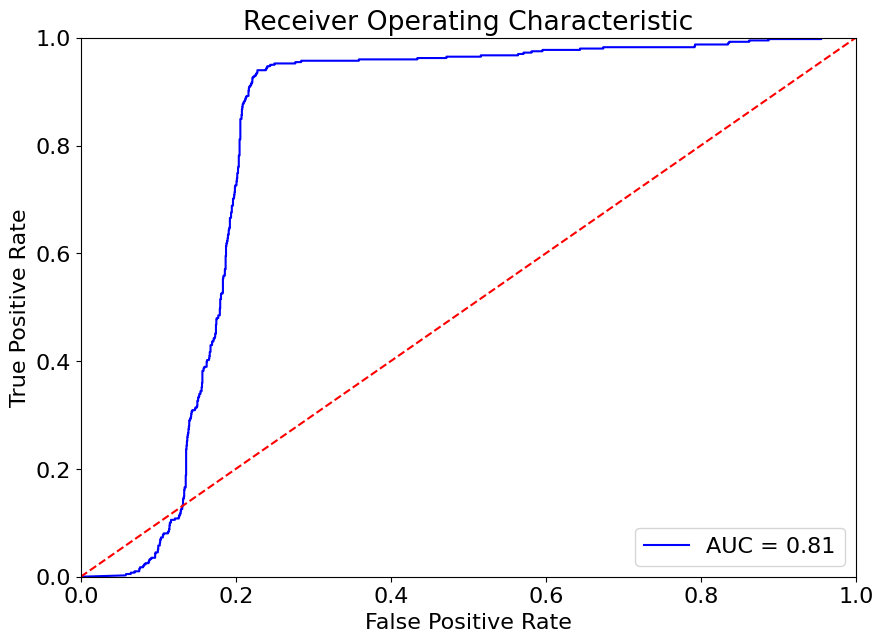

In [111]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test,
                                         y_pred_proba_test)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()